<a href="https://colab.research.google.com/github/israelvirtual/CISTraineePeriod/blob/main/Periodo0/desafioCIS_Israel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Observação inicial
Para poder rodar bem o notebook, favor começar subindo os arquivos das bases de dados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import io
import seaborn as sns
from random import randint

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving countries.xlsx to countries (2).xlsx
Saving hapiness_report.xlsx to hapiness_report (2).xlsx
Saving human_freedom.xlsx to human_freedom (2).xlsx
Saving medals_olympics.xlsx to medals_olympics (2).xlsx


In [ ]:
# Datasets
HF = pd.read_excel('/content/human_freedom.xlsx')
MO = pd.read_excel('/content/medals_olympics.xlsx')
Countries = pd.read_excel('/content/countries.xlsx')
HR = pd.read_excel('/content/hapiness_report.xlsx')

# Respostas às questões
Incialemente é interessante termos uma ideia de como os dados vêm estruturados. Na célula acima, eu deszipei o arquivo com o banco de dados para explorá-lo

###Questão 1

* No dataset human_freedom, existem alguns valores faltantes. Antes de
começar a manipular os dados, trate essas informações e descreva
sucintamente as alterações feitas;

Nessa questão é preciso lidar com os dados faltantes do banco de dados proposto

In [ ]:
HF.head()

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
0,2018,AUS,australia,Oceania,8.68,5.0,9.12,10.0,8.23,5.0,9.6,10.0
1,2017,AUS,australia,Oceania,8.66,6.0,9.13,11.0,8.18,7.0,9.7,10.0
2,2016,AUS,australia,Oceania,8.63,6.0,9.10,11.0,8.16,8.0,9.6,10.0
3,2015,AUS,australia,Oceania,8.62,6.0,9.13,11.0,8.10,11.0,9.6,10.0
4,2014,AUS,australia,Oceania,8.69,6.0,9.26,8.0,8.11,10.0,9.6,10.0


* As duas células abaixo apenas mostram alguns elementos dessa planilha, observe que de HF.info() vemos que são 572 entradas (países em anos diferentes), mas apenas 562 scores. Em describe, vemos alguns valores estatísticos que podem eventualmente ser relevantes.

In [ ]:
HF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            572 non-null    int64  
 1   ISO_code        572 non-null    object 
 2   countries       572 non-null    object 
 3   region          572 non-null    object 
 4   hf_score        562 non-null    float64
 5   hf_rank         562 non-null    float64
 6   pf_score        562 non-null    float64
 7   pf_rank         562 non-null    float64
 8   ef_score        562 non-null    float64
 9   ef_rank         562 non-null    float64
 10  pf_ss_homicide  562 non-null    float64
 11  womens_freedom  562 non-null    float64
dtypes: float64(8), int64(1), object(3)
memory usage: 53.8+ KB


In [ ]:
HF.describe()

,year,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
count,572.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.00000,562.00000,562.000000
mean,2013.000000,7.587011,52.412811,7.914075,53.092527,7.255089,54.72242,8.30516,9.008043
std,3.165046,1.094915,44.817320,1.390772,45.211982,0.946596,42.78868,2.67963,2.009926
min,2008.000000,3.850000,1.000000,3.600000,1.000000,2.720000,1.00000,0.00000,0.280000
25%,2010.000000,6.890000,15.000000,7.027500,17.000000,6.880000,20.25000,8.30000,9.260000
50%,2013.000000,8.015000,37.000000,8.530000,35.500000,7.520000,43.00000,9.50000,10.000000
75%,2016.000000,8.450000,84.000000,9.047500,86.750000,7.807500,81.00000,9.70000,10.000000
max,2018.000000,8.990000,161.000000,9.590000,159.000000,8.970000,162.00000,9.90000,10.000000


Aqui, temos algumas coisas para averiguar antes de decidir o que fazer com os valores que faltam. Por exemplo, se são valores referentes a um único país, dropar esses valores provavelmente será o mais razoável, caso contrário, uma interpolação de valores de anos adjacentes é bem vinda. Para isso, vamos primeiro definir as colunas que não são objetos.

In [ ]:
notAnObject = HF.columns[HF.dtypes!='object']

In [ ]:
HF[notAnObject].isnull()

,year,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
567,False,False,False,False,False,False,False,False,False
568,False,False,False,False,False,False,False,False,False
569,False,False,False,False,False,False,False,False,False
570,False,False,False,False,False,False,False,False,False


In [ ]:
null_data = HF[HF.isnull().any(axis=1)]
null_data

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
25,2015,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2014,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2013,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2012,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,2011,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,2010,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,2009,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2008,BLR,belarus,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394,2009,QAT,qatar,Middle East & North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,2008,QAT,qatar,Middle East & North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Da linha acima, vemos que quase todos os dados de Belarus estão faltando, de forma que para esse caso dropar TODOS os valores de Belarus, inclusive os dos anos 2016,2017 e 2018 é algo razoável (isso pois a incompletude dos dados pode levar a problemas de análise posterior). No caso do Catar, como são apenas dois anos faltantes, a interpolação linear é uma opção mais interessante

In [ ]:
HF_new=HF.drop(range(23,33),axis=0)

In [ ]:
HF_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 0 to 571
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            562 non-null    int64  
 1   ISO_code        562 non-null    object 
 2   countries       562 non-null    object 
 3   region          562 non-null    object 
 4   hf_score        560 non-null    float64
 5   hf_rank         560 non-null    float64
 6   pf_score        560 non-null    float64
 7   pf_rank         560 non-null    float64
 8   ef_score        560 non-null    float64
 9   ef_rank         560 non-null    float64
 10  pf_ss_homicide  560 non-null    float64
 11  womens_freedom  560 non-null    float64
dtypes: float64(8), int64(1), object(3)
memory usage: 57.1+ KB


In [ ]:
HF_new.iloc[23]

year                        2018
ISO_code                     BEL
countries                belgium
region            Western Europe
hf_score                    8.28
hf_rank                       25
pf_score                    8.99
pf_rank                       17
ef_score                    7.56
ef_rank                       49
pf_ss_homicide               9.3
womens_freedom                10
Name: 33, dtype: object

Como visto acima, conseguimos nos livrar dos valores para Belarus (na posição 23 agora temos o país seguinte)

In [ ]:
HF_new2=HF_new.interpolate(method='linear',limit_direction='backward')
HF_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 0 to 571
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            562 non-null    int64  
 1   ISO_code        562 non-null    object 
 2   countries       562 non-null    object 
 3   region          562 non-null    object 
 4   hf_score        562 non-null    float64
 5   hf_rank         562 non-null    float64
 6   pf_score        562 non-null    float64
 7   pf_rank         562 non-null    float64
 8   ef_score        562 non-null    float64
 9   ef_rank         562 non-null    float64
 10  pf_ss_homicide  562 non-null    float64
 11  womens_freedom  562 non-null    float64
dtypes: float64(8), int64(1), object(3)
memory usage: 57.1+ KB


In [ ]:
HF_new2.loc[HF_new2['ISO_code']=='QAT']

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
385,2018,QAT,qatar,Middle East & North Africa,6.07,129.000000,5.260000,143.000000,6.880000,83.000000,9.800000,3.000000
386,2017,QAT,qatar,Middle East & North Africa,6.11,128.000000,5.250000,145.000000,6.960000,79.000000,9.800000,3.000000
387,2016,QAT,qatar,Middle East & North Africa,6.19,124.000000,5.280000,145.000000,7.090000,74.000000,9.800000,3.000000
388,2015,QAT,qatar,Middle East & North Africa,6.27,117.000000,5.510000,136.000000,7.030000,78.000000,9.800000,3.000000
389,2014,QAT,qatar,Middle East & North Africa,6.38,111.000000,5.480000,140.000000,7.280000,62.000000,9.800000,3.000000
390,2013,QAT,qatar,Middle East & North Africa,6.45,112.000000,5.760000,133.000000,7.140000,69.000000,9.800000,3.000000
391,2012,QAT,qatar,Middle East & North Africa,6.47,105.000000,5.820000,125.000000,7.110000,66.000000,9.900000,2.100000
392,2011,QAT,qatar,Middle East & North Africa,6.16,119.000000,5.380000,139.000000,6.940000,77.000000,9.900000,2.100000
393,2010,QAT,qatar,Middle East & North Africa,6.23,121.000000,5.330000,145.000000,7.130000,61.000000,9.900000,2.100000
394,2009,QAT,qatar,Middle East & North Africa,6.85,91.333333,6.333333,108.666667,7.363333,48.333333,9.766667,4.733333


Observe que os valores acima estão interpolados. No entanto, é evidente que eles interpolam com os valores subsequentes da tabela. Eu tentei pesquisar métodos para restringir o intervalo de interpolação, mas não consegui pensar em nada.

###Questão 2

* Calcule o número total de medalhas recebido por cada país e adicione
essa coluna no dataset;

A resposta para essa questão nao precisa de muita explicação. Lemos o arquivo como antes, exploramos um pouco com o método head(), somamos através das colunas para obtermos a newColumn. Para acrescentar coluna basta criar uma com o nome que queremos

In [ ]:
MO.head()

,Country,Gold Medal,Silver Medal,Bronze Medal
0,unitedstates,39,41,33
1,china,38,32,18
2,japan,27,14,17
3,unitedkingdom,22,21,22
4,russia,20,28,23


In [ ]:
newColumn = MO.sum(axis=1)
newColumn.head()

0    113
1     88
2     58
3     65
4     71
dtype: int64

In [ ]:
MO['Total']=newColumn
MO.head()

,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,39,41,33,113
1,china,38,32,18,88
2,japan,27,14,17,58
3,unitedkingdom,22,21,22,65
4,russia,20,28,23,71


###Questão 3

* Seguindo as regras oficiais das Olimpíadas, obtenha o ranking dos
países. Visualize, também, os dez melhores países com base no total de
medalhas;

As regras oficiais da olimpíada classifica os países segundo o número de medalhas de ouro, depois de prata, depois de bronze. Vamos começar com  o número total de paísses com base no número total de medalhas

In [ ]:
MO_tot = MO.sort_values(by=['Total'],ascending = False)
MO_tot=MO_tot
MO_tot.head(10)

,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,39,41,33,113
1,china,38,32,18,88
4,russia,20,28,23,71
3,unitedkingdom,22,21,22,65
2,japan,27,14,17,58
5,australia,17,7,22,46
9,italy,10,10,20,40
8,germany,10,11,16,37
6,netherlands,10,12,14,36
7,france,10,12,11,33


<Figure size 1440x2160 with 0 Axes>

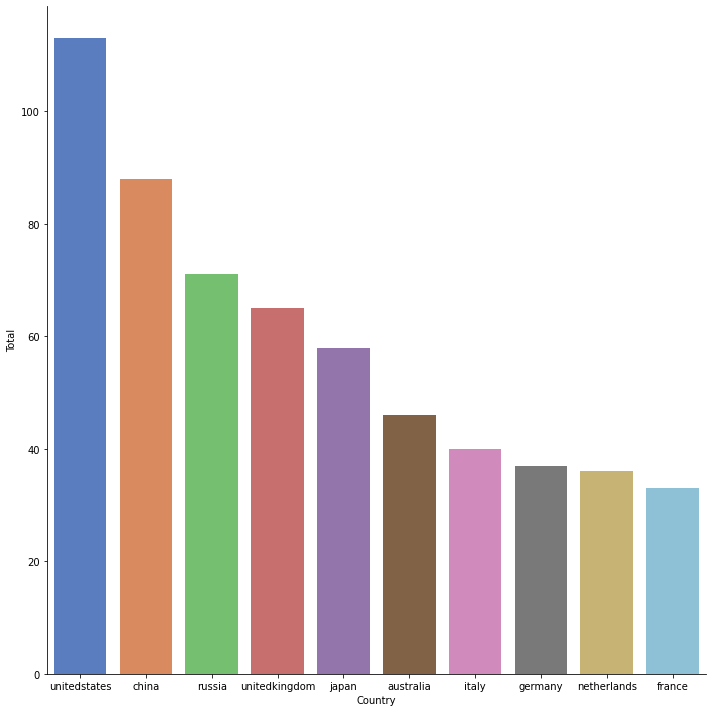

In [ ]:
plt.figure(figsize=(20, 30))

sns.catplot(x="Country", y="Total", data=MO_tot.head(10),
                height=10, kind="bar", palette="muted")
plt.show()

Agora o número de medalhas de acordo com as regras oficiais. Aqui, basta ordenar de trás para frente, pegando sempre a última tabela ordenada

In [ ]:
MO_ol = MO.sort_values(by=['Bronze Medal'],ascending = False)
MO_ol = MO_ol.sort_values(by=['Silver Medal'],ascending = False)
MO_ol = MO_ol.sort_values(by=['Gold Medal'],ascending = False)
MO_ol.head(10)

,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,39,41,33,113
1,china,38,32,18,88
2,japan,27,14,17,58
3,unitedkingdom,22,21,22,65
4,russia,20,28,23,71
5,australia,17,7,22,46
6,netherlands,10,12,14,36
7,france,10,12,11,33
8,germany,10,11,16,37
9,italy,10,10,20,40


Aqui vemos que os dez primeiros colocados são de fato os que vemos dos índices 0 a 9 na tabela acima

In [ ]:
sns.catplot(x="Country", y="Gold Medal", data=MO_ol.head(10),
                height=10, kind="bar", palette="muted")
plt.show()

###Questão 4

* Obtenha a média de alfabetização por região e a represente
graficamente;


In [ ]:
Countries.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,australia,OCEANIA,20264082,7686850,2.6,0.34,3.98,4.69,29000,100.0,565.5,6.55,0.04,93.41,1.0,12.14,7.51,0.038,0.262,0.700
1,austria,WESTERN EUROPE,8192880,83870,97.7,0.00,2.00,4.66,30000,98.0,452.2,16.91,0.86,82.23,3.0,8.74,9.76,0.018,0.304,0.678
2,belarus,C.W. OF IND. STATES,10293011,207600,49.6,0.00,2.54,13.37,6100,99.6,319.1,29.55,0.60,69.85,4.0,11.16,14.02,0.093,0.316,0.591
3,belgium,WESTERN EUROPE,10379067,30528,340.0,0.22,1.23,4.68,29100,98.0,462.6,23.28,0.40,76.32,3.0,10.38,10.27,0.010,0.240,0.749
4,brazil,LATIN AMER. & CARIB,188078227,8511965,22.1,0.09,-0.03,29.61,7600,86.4,225.3,6.96,0.90,92.15,2.0,16.56,6.17,0.084,0.400,0.516


In [ ]:
Regioes = Countries['Region'].unique()
print(Regioes)

['OCEANIA                            '
 'WESTERN EUROPE                     ' 'C.W. OF IND. STATES '
 'LATIN AMER. & CARIB    ' 'EASTERN EUROPE                     '
 'NORTHERN AMERICA                   ' 'ASIA (EX. NEAR EAST)         '
 'SUB-SAHARAN AFRICA                 '
 'NEAR EAST                          ']


In [ ]:
Media = []
for name in Regioes:
  Temp = Countries.loc[Countries['Region'] == name]
  Media.append(Temp['Literacy (%)'].mean())
print(Media)

[99.5, 98.71428571428571, 99.475, 90.05000000000001, 98.41250000000001, 97.0, 87.66666666666667, 71.025, 88.13333333333333]


In [ ]:
dados = {'Regions':Regioes, 'Literacy Average':Media}
dataFrame = pd.DataFrame(data = dados)

dataFrame

,Regions,Literacy Average
0,OCEANIA,99.500000
1,WESTERN EUROPE,98.714286
2,C.W. OF IND. STATES,99.475000
3,LATIN AMER. & CARIB,90.050000
4,EASTERN EUROPE,98.412500
5,NORTHERN AMERICA,97.000000
6,ASIA (EX. NEAR EAST),87.666667
7,SUB-SAHARAN AFRICA,71.025000
8,NEAR EAST,88.133333


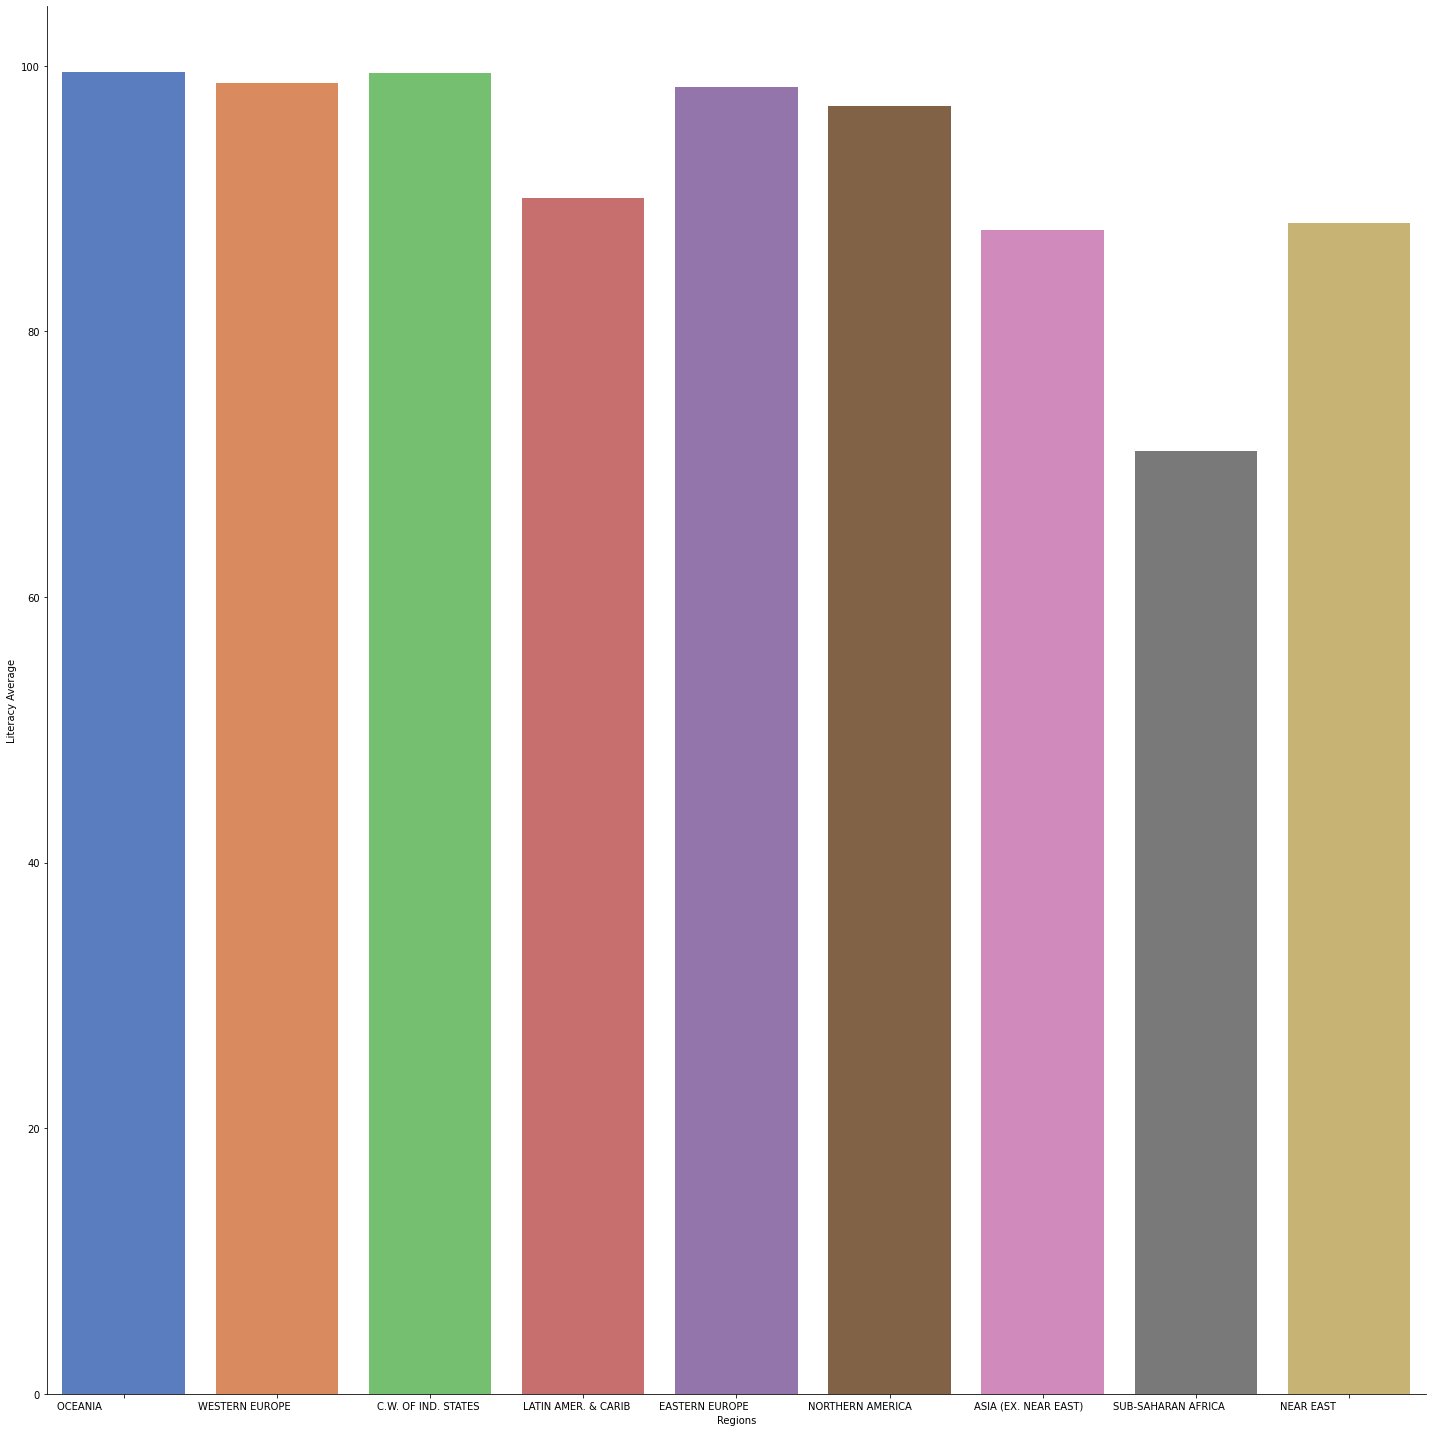

In [ ]:
sns.catplot(x="Regions", y="Literacy Average", data=dataFrame,
                height = 20, kind="bar", palette="muted")
plt.show()

### Questão 5

* Liste os cinco países com maior número de celulares a cada mil
habitantes. Faça uma representação gráfica;

In [ ]:
phonesPerCountry = Countries.sort_values(by='Phones (per 1000)', ascending = False)
phonesPerCountry = phonesPerCountry.head(5)
phonesPerCountry

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
45,unitedstates,NORTHERN AMERICA,298444215,9631420,31.0,0.21,3.41,6.50,37800,97.0,898.0,19.13,0.22,80.65,3.0,14.14,8.26,0.010,0.204,0.787
38,sweden,WESTERN EUROPE,9016596,449964,20.0,0.72,1.67,2.77,26800,99.0,715.0,6.54,0.01,93.45,3.0,10.27,10.31,0.011,0.282,0.707
39,switzerland,WESTERN EUROPE,7523934,41290,182.2,0.00,4.05,4.39,32700,99.0,680.9,10.42,0.61,88.97,3.0,9.71,8.49,0.015,0.340,0.645
15,germany,WESTERN EUROPE,82422299,357021,230.9,0.67,2.18,4.16,27600,99.0,667.9,33.85,0.59,65.56,3.0,8.25,10.62,0.009,0.296,0.695
10,denmark,WESTERN EUROPE,5450661,43094,126.5,16.97,2.48,4.56,31100,100.0,614.6,54.02,0.19,45.79,3.0,11.13,10.36,0.018,0.246,0.735


<Figure size 1440x2160 with 0 Axes>

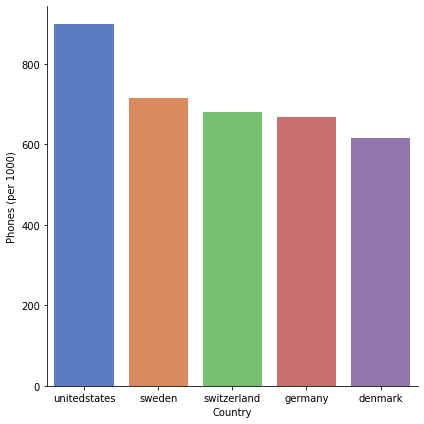

In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 30))

sns.catplot(x="Country", y="Phones (per 1000)", data=phonesPerCountry,
                height=6, kind="bar", palette="muted")
plt.show()

###Questao 6

* Obtenha os dados do dataset human_freedom apenas para o ano de
2018;


In [ ]:
HF2018 = HF[HF['year']==2018]
HF2018

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
0,2018,AUS,australia,Oceania,8.68,5.0,9.12,10.0,8.23,5.0,9.6,10.00
11,2018,AUT,austria,Western Europe,8.45,15.0,9.09,15.0,7.80,26.0,9.6,10.00
22,2018,BLR,belarus,Eastern Europe,6.67,99.0,6.99,85.0,6.35,114.0,9.0,10.00
33,2018,BEL,belgium,Western Europe,8.28,25.0,8.99,17.0,7.56,49.0,9.3,10.00
44,2018,BRA,brazil,Latin America & the Caribbean,6.83,88.0,7.10,78.0,6.56,105.0,0.0,10.00
55,2018,BGR,bulgaria,Eastern Europe,7.93,37.0,8.11,41.0,7.74,32.0,9.5,10.00
66,2018,CAN,canada,North America,8.64,6.0,9.10,13.0,8.17,9.0,9.3,10.00
77,2018,CHN,china,East Asia,6.07,129.0,5.92,125.0,6.21,124.0,9.8,10.00
88,2018,HRV,croatia,Eastern Europe,7.92,38.0,8.47,33.0,7.36,61.0,9.8,10.00
99,2018,CZE,czechrepublic,Eastern Europe,8.29,24.0,8.76,24.0,7.81,25.0,9.8,10.00


###Questao 7

* Mostre a evolução do hf_score (human freedom score) do Brasil em
função do tempo;

Aqui podemos fazer um novo dataframe somente para o Brasil. Ordenas de trás pra frente e plotar

In [ ]:
HF_Brasil = HF[HF['countries']=='brazil']
HF_Brasil

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
44,2018,BRA,brazil,Latin America & the Caribbean,6.83,88.0,7.10,78.0,6.56,105.0,0.0,10.00
45,2017,BRA,brazil,Latin America & the Caribbean,6.89,81.0,7.23,72.0,6.54,106.0,0.0,10.00
46,2016,BRA,brazil,Latin America & the Caribbean,6.68,98.0,6.91,87.0,6.45,108.0,0.0,8.50
47,2015,BRA,brazil,Latin America & the Caribbean,6.68,98.0,7.15,75.0,6.20,121.0,0.0,8.50
48,2014,BRA,brazil,Latin America & the Caribbean,6.93,79.0,7.46,65.0,6.40,113.0,0.0,8.50
49,2013,BRA,brazil,Latin America & the Caribbean,6.99,78.0,7.48,62.0,6.50,109.0,0.0,8.50
50,2012,BRA,brazil,Latin America & the Caribbean,7.12,68.0,7.61,60.0,6.63,95.0,0.0,9.26
51,2011,BRA,brazil,Latin America & the Caribbean,7.21,65.0,7.74,58.0,6.68,92.0,0.3,9.26
52,2010,BRA,brazil,Latin America & the Caribbean,7.34,60.0,8.01,51.0,6.66,93.0,1.2,10.00
53,2009,BRA,brazil,Latin America & the Caribbean,7.24,62.0,7.99,51.0,6.49,93.0,0.9,10.00


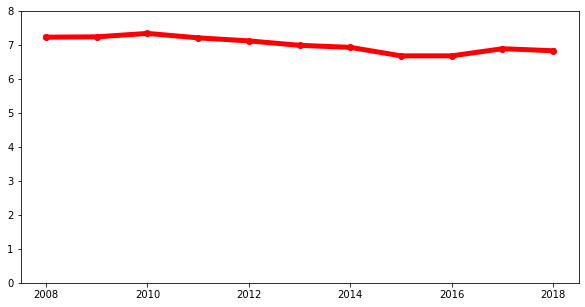

In [ ]:
HF_Brasil=HF_Brasil.sort_values(by='year',ascending =False)

plt.figure(figsize=(10, 5))

plt.plot(HF_Brasil['year'],HF_Brasil['hf_score'],'ro-',linewidth=5)
plt.ylim(0,8)
plt.show()

###Questao 8

* Mostre qual é a região com a maior média populacional;

Vamos retomar um dataframe por região em temp, e fazer um vetor de médias

In [ ]:

media = []

for name in Regioes:
   temp = Countries[Countries['Region']==name]
   media.append(temp['Population'].mean())
#print(media)

maior = np.amax(media)
index = media.index(maior)
print ("Maior media populacional presente na regiao "+Regioes[index])

Maior media populacional presente na regiao ASIA (EX. NEAR EAST)         


Para referência, abaixo podemos ver o dataframe de médias de população

In [ ]:
data = {'Regions':Regioes,'Media populacional':media}
df = pd.DataFrame(data)
df

,Regions,Media populacional
0,OCEANIA,1.217011e+07
1,WESTERN EUROPE,2.706105e+07
2,C.W. OF IND. STATES,5.113971e+07
3,LATIN AMER. & CARIB,5.752857e+07
4,EASTERN EUROPE,1.304301e+07
5,NORTHERN AMERICA,1.657716e+08
6,ASIA (EX. NEAR EAST),4.824578e+08
7,SUB-SAHARAN AFRICA,4.546730e+07
8,NEAR EAST,2.588381e+07


###Questao 9

* Com base na análise dos dados, é possível afirmar que países com maior
população tendem a ter mais pessoas saindo ou entrando no país (maior
fluxo migratório)?

Aqui, podemos usar o método Corr(), que associa bem o qual relacionadas duas variáveis são

In [ ]:
column0 = Countries['Country']
column1 = Countries['Population']
column2 = Countries['Net migration']

data ={'Countries':column0, 'Population': column1, 'Net migration': column2}
df = pd.DataFrame(data)
df = df.sort_values(by='Population', ascending = False)
df.head(10)

,Countries,Population,Net migration
7,china,1313973713,-0.40
18,india,1095351995,-0.07
45,unitedstates,298444215,3.41
19,indonesia,245452739,0.00
4,brazil,188078227,-0.03
33,russia,142893540,1.02
24,japan,127463611,0.00
29,philippines,89468677,-1.50
15,germany,82422299,2.18
12,ethiopia,74777981,0.00


Observe que a primeira vista não parece existir correlação nenhuma. Uma boa correlação vai oferecer valores do método corr() próximos de 1 ou -1. Abaixo vemos que a correlação é na verdade próxima de 0, logo, negligenciável

In [ ]:

correlacao = column1.corr(column2)
correlacao

-0.08053570767888385

###Questao 10

* Caso o número de medalhas de bronze e de ouro fossem trocadas, qual
seria o ranking dos países?

A ideia aqui é fazer uma troca entre as colunas de bronze e ouro antes de reordenar

In [ ]:
ouro = MO['Gold Medal']
bronze = MO['Bronze Medal']

MO_new = MO.copy()
MO_new['Gold Medal'] = bronze
MO_new['Bronze Medal'] = ouro

MO_new.head()

,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,33,41,39,113
1,china,18,32,38,88
2,japan,17,14,27,58
3,unitedkingdom,22,21,22,65
4,russia,23,28,20,71


Com essa troca feita, o código é o mesmo que vimos na questão 3

In [ ]:
MO_ol_new = MO_new.sort_values(by=['Bronze Medal'],ascending = False)
MO_ol_new = MO_ol_new.sort_values(by=['Silver Medal'],ascending = False)
MO_ol_new = MO_ol_new.sort_values(by=['Gold Medal'],ascending = False)
MO_ol_new.head(10)



,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,33,41,39,113
4,russia,23,28,20,71
3,unitedkingdom,22,21,22,65
5,australia,22,7,17,46
9,italy,20,10,10,40
1,china,18,32,38,88
2,japan,17,14,27,58
8,germany,16,11,10,37
6,netherlands,14,12,10,36
39,ukraine,12,6,1,19


<Figure size 1440x2160 with 0 Axes>

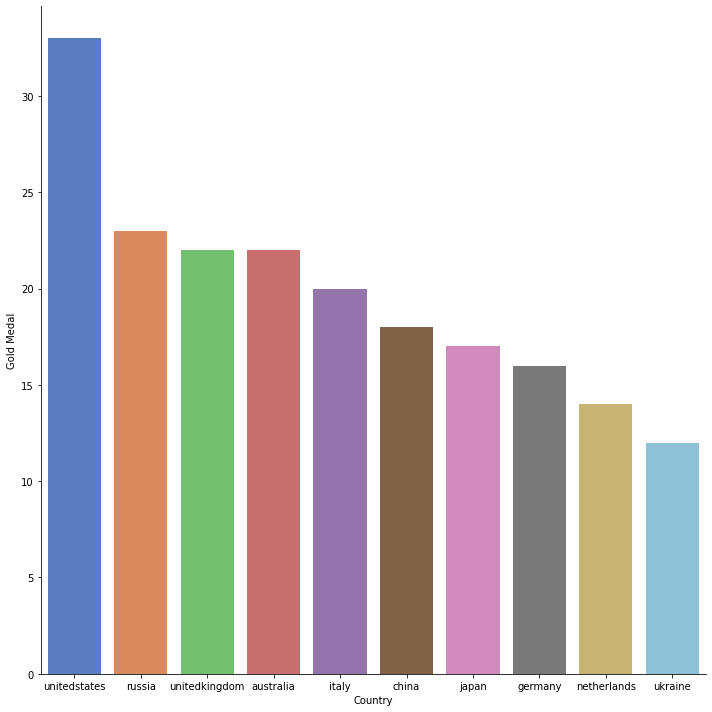

In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 30))

sns.catplot(x="Country", y="Gold Medal", data=MO_ol_new.head(10),
                height=10, kind="bar", palette="muted")
plt.show()

###Questão 11

* Normalize os valores dos datasets

A normalização de dados é uma parte muito importante de ciência de dados de forma geral e consistem em encaixar os dados entre 0 e 1. Segundo https://stackoverflow.com/questions/65029540/normalize-dataset-in-python#:~:text=In%20order%20to%20normalize%20a%20dataset%20you%20simply,and%20divide%20the%20result%20by%20the%20standard%20deviation., uma forma de fazer isso [e fazer a operaçao (data-min)/(max-min)


In [ ]:
def norm(df):
  df.columns
  notObject = df.columns[df.dtypes!='object']
  #df[notObject]
  for name in notObject:
    df[name] = (df[name]-df[name].min())/(df[name].max()-df[name].min())
  return df


O código acima é uma função que é capaz de normalizar dataframes entre 0 e 1. No entanto, eu fico ainda um pouco em dúvida, pois valores como ano nao fazem sentido serem normalizados, suponho

In [ ]:
HF_norm = norm(HF)
MO_norm = norm(MO)
Countries_norm = norm(Countries)
HR_norm = norm(HR)

HF_norm.head()


,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
0,1.0,AUS,australia,Oceania,0.939689,0.02500,0.921536,0.056962,0.8816,0.024845,0.969697,1.0
1,0.9,AUS,australia,Oceania,0.935798,0.03125,0.923205,0.063291,0.8736,0.037267,0.979798,1.0
2,0.8,AUS,australia,Oceania,0.929961,0.03125,0.918197,0.063291,0.8704,0.043478,0.969697,1.0
3,0.7,AUS,australia,Oceania,0.928016,0.03125,0.923205,0.063291,0.8608,0.062112,0.969697,1.0
4,0.6,AUS,australia,Oceania,0.941634,0.03125,0.944908,0.044304,0.8624,0.055901,0.969697,1.0


In [ ]:
MO_norm.head()

,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,1.000000,1.000000,1.000000,1.000000
1,china,0.973684,0.780488,0.545455,0.772727
2,japan,0.684211,0.341463,0.515152,0.500000
3,unitedkingdom,0.552632,0.512195,0.666667,0.563636
4,russia,0.500000,0.682927,0.696970,0.618182


In [ ]:
Countries_norm.head()


,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,australia,OCEANIA,0.014758,0.449822,0.000000,0.020035,0.505026,0.020746,0.762803,1.000000,0.628242,0.089976,0.002385,0.916294,0.000000,0.099488,0.184581,0.076110,0.232194,0.852542
1,austria,WESTERN EUROPE,0.005565,0.004271,0.149130,0.000000,0.425412,0.020421,0.789757,0.965096,0.501565,0.279824,0.051282,0.716330,0.666667,0.012532,0.311199,0.033827,0.292023,0.815254
2,belarus,C.W. OF IND. STATES,0.007165,0.011522,0.073702,0.000000,0.447125,0.114533,0.145553,0.993019,0.352750,0.511453,0.035778,0.494903,1.000000,0.074425,0.550929,0.192389,0.309117,0.667797
3,belgium,WESTERN EUROPE,0.007230,0.001145,0.529089,0.012964,0.394451,0.020637,0.765499,0.965096,0.513193,0.396555,0.023852,0.610624,0.666667,0.054476,0.339899,0.016913,0.200855,0.935593
4,brazil,LATIN AMER. & CARIB,0.142559,0.498176,0.030579,0.005303,0.343788,0.290005,0.185984,0.762653,0.247876,0.097489,0.053667,0.893758,0.333333,0.212532,0.109173,0.173362,0.428775,0.540678


In [ ]:
HR_norm.head()

,Overall rank,Countryorregion,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,0.000000,denmark,1.000000,0.777367,0.990175,0.857364,0.979478,0.506024,1.000000
1,0.007246,norway,0.987169,0.855030,1.000000,0.906977,1.000000,0.544177,0.830049
2,0.021739,netherlands,0.968759,0.786982,0.934498,0.862016,0.914179,0.646586,0.724138
3,0.028986,switzerland,0.966527,0.828402,0.938865,0.944186,0.942164,0.528112,0.834975
4,0.036232,sweden,0.928312,0.780325,0.896288,0.877519,0.945896,0.536145,0.908867


###Questão 12
Correlação entre o índice de natalidade e mortalidade. Esse é relativamente previsível, fora uma pequena margem devido ao nível de desenvolvimento do país, é esperado que maior taxa de natalidade esteja correlacionada e maior taxa de normalidade, ambas causadas por IDH, basicamente. Ou seja, em países onde há mais qualidade de vidas, as pessoas morrem menos por avanços na medicina, e menos pessoas nascem pois sabe-se do custo e trabalho que é ter filhos. Mas lembre-se, correlação não é causa. A causa é o quão desenvolvido é o país

In [ ]:
df = Countries[['Country','Birthrate','Deathrate']]
df.head()

,Country,Birthrate,Deathrate
0,australia,0.099488,0.184581
1,austria,0.012532,0.311199
2,belarus,0.074425,0.550929
3,belgium,0.054476,0.339899
4,brazil,0.212532,0.109173


In [ ]:
correlacao = Countries['Birthrate'].corr(Countries['Deathrate'])
print("A correlação entre as taxas de natalidade e mortalidade é "+str (correlacao))

A correlação entre as taxas de natalidade e mortalidade é 0.046391856197479105


Observe que na verdade foi encontrada uma correlação negligenciável. Isso faz sentido no quesito que certo países, mesmo que desenvolvidos e com menor natalidade, têm costumes diferentes quanto a famílias. Enquanto no Japão a população decresce pois filhos são considerados uma alta despensa, na França e Estados Unidos filhos são considerados como legado.


###Questao 13

* É possível observar correlação entre a generosidade da população e o
índice de agricultura dos países? Justifique o resultado encontrado;

In [ ]:
HRcopy = HR.copy()
HRcopy = HRcopy.sort_values(by='Countryorregion')

In [ ]:
c1 = HRcopy['Countryorregion']
c2 = Countries['Country']
c1.values==c2.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
correlacao=Countries['Agriculture'].corr(HRcopy['Generosity'])
print ("A correlação entre a agriculture e generosidade é "+str (correlacao))

A correlação entre a agriculture e generosidade é 0.20243391885027195


Veja acima que na verdade se encontra uma correlação não negligenciável entre as duas variáveis. Isso faz até sentido, pois quanto maior o índice de agricultura mais pessoas habitam em meios rurais, pessoas conhecidas pela sua generosidade e senso de partilha

###Questao 14

* Monte grupos de forma similar a é feito na Copa do Mundo, isto é, um
forte, dois intermediários e um fraco (deixe claro o parâmetro utilizado
para definir as categorias);

Para essa parte, para escolher grupos de um evento esportivo, não temos escolha a não ser usar algum parâmetro do quadro de medalhas. Acredito que usar o número total de medalhas seja um parâmetro melhor, pois quem ganha mais medalhas, e não só medalhas de um tipo é mais consistente

In [ ]:
#Função que escolhe aleatoriamente dentro de cada array e entrega de volta o array sem o elemento
#retirado e o elemento retirado

def randompicking(array):
  if len(array)>1:
    index = randint(0,len(array)-1)
  else:
    index = 0
  choose = array[index]
  array=np.delete(array,index)
  return choose, array

In [ ]:
# Divisão dos países em três grupos de diferentes forças

NoPaises = len(MO_tot.index)
NoPaises

F = MO_tot.iloc[0:int(NoPaises/4)]['Country'].values
M = MO_tot.iloc[int(NoPaises/4+1):int(3*NoPaises/4)]['Country'].values
Fr = MO_tot.iloc[int(3*NoPaises/4+1):int(NoPaises)]['Country']. values


In [ ]:
Forte = F
Medio = M
Fraco = Fr
grupos = []
for i in range(int(NoPaises/4-1)):
  A,Forte = randompicking(Forte)
  B,Medio = randompicking(Medio)
  C,Medio = randompicking(Medio)
  D,Fraco = randompicking(Fraco)
  grupos.append([A,B,C,D])



In [ ]:
Grupos = pd.DataFrame(grupos)
Grupos

,0,1,2,3
0,australia,slovenia,belarus,ecuador
1,italy,croatia,norway,philippines
2,unitedkingdom,georgia,spain,qatar
3,brazil,turkey,switzerland,romania
4,canada,hongkong,bulgaria,ethiopia
5,netherlands,sweden,taiwan,southafrica
6,russia,egypt,belgium,venezuela
7,china,hungary,jamaica,slovakia
8,japan,poland,denmark,greece
9,germany,kenya,czechrepublic,uganda


Acima, cada fileira representa um grupo e cada coluna a posição do país (0 = forte, 1 e 2 = médio, 3 = fraco)

###Questão 15

* Qual país apresentou maior aumento na taxa de homicídios ao longo do
tempo?

In [ ]:
dfHomicidio = HF[['year','countries','pf_ss_homicide']]

In [ ]:
dfHomicidio['countries'].unique()

array(['australia', 'austria', 'belarus', 'belgium', 'brazil', 'bulgaria',
       'canada', 'china', 'croatia', 'czechrepublic', 'denmark',
       'ecuador', 'egypt', 'ethiopia', 'france', 'georgia', 'germany',
       'greece', 'hongkong', 'hungary', 'india', 'indonesia', 'iran',
       'ireland', 'israel', 'italy', 'jamaica', 'japan', 'kenya',
       'southkorea', 'netherlands', 'newzealand', 'norway', 'philippines',
       'poland', 'qatar', 'romania', 'russia', 'serbia', 'slovakia',
       'slovenia', 'southafrica', 'spain', 'sweden', 'switzerland',
       'taiwan', 'turkey', 'uganda', 'ukraine', 'unitedkingdom',
       'unitedstates', 'venezuela'], dtype=object)

In [ ]:
dfHomicidio = HF[['year','countries','pf_ss_homicide']]
i = 0
increase = []
for pais in dfHomicidio['countries'].unique():
  temp = dfHomicidio.iloc[11*i:11*(i+1)]['pf_ss_homicide'].values
  increase.append((temp[0]-temp[len(temp)-1])/temp[len(temp)-1])
  i = i+1


print(increase)

[0.010526315789473637, -0.010309278350515419, nan, 0.010869565217391495, -1.0, 0.043956043956044, 0.0, 0.02083333333333347, 0.05376344086021504, 0.02083333333333347, 0.0, 1.7500000000000002, -0.05263157894736842, 0.06060606060606066, 0.021505376344085923, 0.19736842105263155, 0.0, 0.010526315789473637, -0.010204081632653239, -0.03225806451612912, 0.03529411764705892, 0.0, 0.022727272727272624, 0.0, 0.02173913043478275, 0.02083333333333347, nan, 0.010204081632653014, -0.090909090909091, 0.010309278350515644, 0.02083333333333347, 0.021052631578947274, -0.020618556701030837, 0.0, 0.021052631578947274, nan, 0.043956043956044, 0.9705882352941178, -0.04255319148936174, 0.021276595744680753, 0.0, nan, 0.02083333333333347, 0.0, 0.010309278350515644, 0.0, 0.0975609756097562, -0.10769230769230771, -0.05063291139240511, 0.0, 0.025641025641025668, nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
i=increase.index(max(increase))
HF.iloc[11*i:11*(i+1)]

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
121,1.0,ECU,ecuador,Latin America & the Caribbean,0.640078,0.40625,0.704508,0.291139,0.5984,0.677019,0.777778,0.923868
122,0.9,ECU,ecuador,Latin America & the Caribbean,0.616732,0.44375,0.679466,0.335443,0.5840,0.689441,0.777778,0.923868
123,0.8,ECU,ecuador,Latin America & the Caribbean,0.614786,0.44375,0.689482,0.348101,0.5712,0.708075,0.777778,1.000000
124,0.7,ECU,ecuador,Latin America & the Caribbean,0.618677,0.45000,0.672788,0.367089,0.5920,0.677019,0.747475,1.000000
125,0.6,ECU,ecuador,Latin America & the Caribbean,0.570039,0.55625,0.662771,0.360759,0.5216,0.795031,0.676768,1.000000
126,0.5,ECU,ecuador,Latin America & the Caribbean,0.570039,0.56875,0.639399,0.405063,0.5456,0.751553,0.565657,1.000000
127,0.4,ECU,ecuador,Latin America & the Caribbean,0.575875,0.56875,0.632721,0.436709,0.5600,0.720497,0.505051,1.000000
128,0.3,ECU,ecuador,Latin America & the Caribbean,0.573930,0.58125,0.647746,0.436709,0.5424,0.751553,0.383838,1.000000
129,0.2,ECU,ecuador,Latin America & the Caribbean,0.579767,0.58125,0.642738,0.417722,0.5568,0.708075,0.303030,1.000000
130,0.1,ECU,ecuador,Latin America & the Caribbean,0.577821,0.56875,0.646077,0.405063,0.5504,0.670807,0.292929,1.000000


Como podemos ver acima, o maior aumento foi do Equador

###Questão 16

* Qual foi o impacto das eleições americanas de 2016 no ranking de
liberdade do país? Explique;

Analisar hf_rank

In [ ]:
USA = HF[HF['ISO_code'] == 'USA']
USA

,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
550,1.0,USA,unitedstates,North America,0.892996,0.10000,0.844741,0.177215,0.8800,0.031056,0.808081,1.000000
551,0.9,USA,unitedstates,North America,0.914397,0.04375,0.859766,0.145570,0.8992,0.024845,0.797980,1.000000
552,0.8,USA,unitedstates,North America,0.908560,0.08125,0.853088,0.164557,0.8960,0.024845,0.797980,1.000000
553,0.7,USA,unitedstates,North America,0.912451,0.07500,0.869783,0.145570,0.8880,0.031056,0.808081,1.000000
554,0.6,USA,unitedstates,North America,0.906615,0.08750,0.876461,0.139241,0.8704,0.043478,0.828283,1.000000
555,0.5,USA,unitedstates,North America,0.892996,0.10000,0.868114,0.151899,0.8560,0.043478,0.828283,1.000000
556,0.4,USA,unitedstates,North America,0.898833,0.07500,0.864775,0.151899,0.8688,0.031056,0.818182,0.985597
557,0.3,USA,unitedstates,North America,0.883268,0.10000,0.851419,0.196203,0.8560,0.037267,0.818182,0.985597
558,0.2,USA,unitedstates,North America,0.887160,0.09375,0.849750,0.215190,0.8640,0.031056,0.818182,0.985597
559,0.1,USA,unitedstates,North America,0.879377,0.10000,0.853088,0.196203,0.8496,0.037267,0.808081,0.985597


In [ ]:
np.average(USA['hf_rank'])

0.08295454545454545

Como é possível ver na tabela gerada pela penúltima célula e a média da última célula, o rank dos EUA saiu de uma média de 14,3 para 8 em 2017, logo após a eleição. Pensaríamos que isse se deve a um aumento de liberdade, mas como vemos da coluna de hf_score, o valor do score bruto não mudou muito em 2017. A conclusão lógica é que seguinda à eleição, a liberdade em outros países caiu, de forma que isso empurrou os valores para cima.

###Questão 17

* É possível observar correlação forte entre a população de um país e a
colocação dele nas Olimpíadas? Justifique;

Questão semelhante à 13. Nesse caso é de se esperar que sim, pois países com mais população podem enviar comitês maiores para as olimpíadas. Retomemos o dataframe MO_ol (Aqui ele está normalizado, mas não faz diferença para a correlação).


In [ ]:
MO_ol.head(10)

,Country,Gold Medal,Silver Medal,Bronze Medal,Total
0,unitedstates,39,41,33,113
1,china,38,32,18,88
2,japan,27,14,17,58
3,unitedkingdom,22,21,22,65
4,russia,20,28,23,71
5,australia,17,7,22,46
6,netherlands,10,12,14,36
7,france,10,12,11,33
8,germany,10,11,16,37
9,italy,10,10,20,40


In [ ]:
MO_ol['Posicao'] = np.linspace(1,MO_ol.shape[0],MO_ol.shape[0])
MO_sorted = MO_ol.sort_values(by='Country')
MO_sorted.head()

,Country,Gold Medal,Silver Medal,Bronze Medal,Total,Posicao
5,australia,17,7,22,46,6.0
48,austria,1,1,5,7,42.0
40,belarus,1,3,3,7,47.0
27,belgium,3,1,3,7,23.0
11,brazil,7,6,8,21,12.0


In [ ]:

c1 = Countries['Population']
c2 = MO_sorted['Posicao']

correlacao = c1.corr(c2)
correlacao

-0.15408584570729403

Observe que a correlação é levemente negativa. Isso é esperado pois há dois fatores que se cancelam aqui. Ao passo que países menores são avantajados por poderem enviar uma quantidade similar de atletas que países bem maiores, os países maiores, devido a essa mesma restrição, tendem a enviar mais atletas com chance real de medalha. Assim, os poucos que eles enviam proporcionalemente se dão bem.

###Questao 18

* Em quais características o Brasil precisa investir para melhorar sua
colocação no ranking olímpico? Encontre a característica mais importante
entre todos os datasets;

Para essa pegunta, pode-se refrasear como: qual é a característica que mais se correlaciona à posição de um país na olimpíada? Esse é um código relativamente grande que deverá rodar uma correlação entre todas as colunas de todas as outras tabelas e a coluna posição do dataframe da questão 17. Após isso, é preciso uma análise de qual característica tem maior correlação, pois se for algo imutável não é uma opção viável. Para Human Freedom, toma-se o valor mais recente (2018)

In [ ]:

#correlacoes em HF
def dfCorrelation (c_ref, df):
  correlation=[]
  notAnObject = df.columns[df.dtypes!='object']
  for name in notAnObject:
    correlation.append(c_ref.corr(df[name]))

  #A linha abaixo é incluída pois o método corr atribui NaN para correlações sem sentido (por exemplo, todos os anos avaliados sao 2018)
  #Assim, zeramos esse valores
  
  for i in pd.isna(correlation):
    correlation[i]= 0
  correlation = np.array(correlation)
  correlac = np.abs(correlation)
  Index = np.where(correlac==max(correlac))
  #coluna=notAnObject[Index]
  return correlation[Index], notAnObject[Index]

c_ref = MO_sorted['Posicao']
ano = max(HF['year'])
HF2018=HF[( HF['year']==ano)] #Caso esteja normalizado ou não

A,b = dfCorrelation(c_ref,HF2018)

print("Temos que para a tabela Human Freedom, a maior correlação está na coluna " + b+" com valor "+ str(A))


Index(['Temos que para a tabela Human Freedom, a maior correlação está na coluna ef_rank com valor [0.7700117]'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Vamos analizar as duas colunas para ver se de fato faz sentido

In [ ]:
data = {'Pais':HF2018['countries'].values,
    'Posicao':c_ref.values,
        'Comparar': HF2018['ef_rank'].values}

#df = pd.DataFrame(data)
#df.head()
np.size(HF2018['ef_rank'].values)
HF2018.head()


,year,ISO_code,countries,region,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank,pf_ss_homicide,womens_freedom
0,1.0,AUS,australia,Oceania,0.939689,0.02500,0.921536,0.056962,0.8816,0.024845,0.969697,1.0
11,1.0,AUT,austria,Western Europe,0.894942,0.08750,0.916528,0.088608,0.8128,0.155280,0.969697,1.0
22,1.0,BLR,belarus,Eastern Europe,0.548638,0.61250,0.565943,0.531646,0.5808,0.701863,0.909091,1.0
33,1.0,BEL,belgium,Western Europe,0.861868,0.15000,0.899833,0.101266,0.7744,0.298137,0.939394,1.0
44,1.0,BRA,brazil,Latin America & the Caribbean,0.579767,0.54375,0.584307,0.487342,0.6144,0.645963,0.000000,1.0


É possível ver uma leve tendência entre ef_rank (comparar) e a Posicao, particularmente para algumas das posições mais elevadas. Com exceções notáveis como China e Rússica, países com maior liberdade econômica tendem a mandar bem nas olimpíadas. Podemos agora rodar a função dfCorrelation nos outros dois dataframes.

In [ ]:
HR_sorted = HR.sort_values(by='Countryorregion')
A,b = dfCorrelation(c_ref,HR_sorted)

print("Temos que para a tabela Human Freedom, a maior correlação está na coluna " + b+" com valor "+ str(max(A)))

Index(['Temos que para a tabela Human Freedom, a maior correlação está na coluna Score com valor -0.956148466964673'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


In [ ]:
A,b = dfCorrelation(c_ref,Countries)

print("Temos que para a tabela Human Freedom, a maior correlação está na coluna " + b+" com valor "+ str(max(A)))

Index(['Temos que para a tabela Human Freedom, a maior correlação está na coluna Pop. Density (per sq. mi.) com valor 0.1669588890717893'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Aqui vemos as caracterísitcas princiapais para cada tabela. Vê-se que liberdade econômica e liberdade humana são as características mais importantes, assim como uma leve correlação de densidade populacional. A questão da densidade populacional se assemelha ao discutido anteriormente, onde países mais densamente povoados têm um banco de talentos maior para o mesmo número de vagas para as olimpíadas.

- Observação: Ao se fazer a questao 20, foi observado que as tabelas MO e Countries na verdade têm alguns países divergentes. O correto para a correlaçao acima seria retirar os países cujos dados não estão em AMBAS as tabelas. Depois de uma consideração de tempo, preferiu-se não refazer essa parte pois o valor de correlação já baixo provavelmente não se alteraria muito.

###Questão 19
* Suponha que a economia do país dependa apenas de agricultura e
indústria. O fato de um país ser litorâneo faz com que ele aposte mais na
agricultura do que na indústria? Explique;

Essa questão parece ser um pouco complicada. Agricultura se beneficia de amplas extensões de terra, enquanto indústria de facilidade de comércio (interior e exterior). Se vermos o padrão internacional, veremos que países litorâneos tendem a ter a indústria mais desenvolvida. Analisemos os dados, eles não mentem.

- Tarefa: Comparar correlação agricultura e litoral com indústria e litoral

In [ ]:
c_ref = Countries['Coastline (coast/area ratio)']
c1 = Countries['Agriculture']
c2 = Countries['Industry']

Vamos fazer duas análises, uma onde consideramos o QUANTO a área costeira influencia nos dois parâmetros ecoômicos, e outra vendo SE ter área costeira influencia. Para o segundo caso, binarizamos os valores de área costeira

In [ ]:
c_ref2 = c_ref.copy()
c_ref2[c_ref2!=0]=1
c_ref2.head()

0    1.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: Coastline (coast/area ratio), dtype: float64

In [ ]:
print("A correlação entre a agricultura e o tamanho da costa do paíse é " +str(c_ref.corr(c1)))
print("A correlação entre a indústria e o tamanho da costa do paíse é " +str(c_ref.corr(c2)))
print("A correlação entre a agricultura e a presença de costa no paíse é " +str(c_ref2.corr(c1)))
print("A correlação entre a indústria e a presença de costa no paíse é " +str(c_ref2.corr(c2)))

A correlação entre a agricultura e o tamanho da costa do paíse é -0.18355053836262802
A correlação entre a indústria e o tamanho da costa do paíse é 0.008387831123958234
A correlação entre a agricultura e a presença de costa no paíse é -0.35998474744926395
A correlação entre a indústria e a presença de costa no paíse é 0.15765704679378337


Vê-se de cara que a agricultura é favorecida quando não há costa no país, enquanto a indústria quando há costa. Novamente, isso tem a ver com questões de comércio interior e exterior, além do tamanho dos países

###Questão 20

* Obtenha o ranking das regiões com maior número médio de medalhas.

Nessa questão queremos combinar a coluna regiões da tabela Countries com a coluna Total feita na questão 3

In [ ]:

Df1=MO_ol.sort_values(by='Country').copy()
Df1.head()

,Country,Gold Medal,Silver Medal,Bronze Medal,Total,Posicao
5,australia,17,7,22,46,6.0
48,austria,1,1,5,7,42.0
40,belarus,1,3,3,7,47.0
27,belgium,3,1,3,7,23.0
11,brazil,7,6,8,21,12.0


In [ ]:
Df2=Countries.copy()
Countries.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,australia,OCEANIA,0.014758,0.449822,0.000000,0.020035,0.505026,0.020746,0.762803,1.000000,0.628242,0.089976,0.002385,0.916294,0.000000,0.099488,0.184581,0.076110,0.232194,0.852542
1,austria,WESTERN EUROPE,0.005565,0.004271,0.149130,0.000000,0.425412,0.020421,0.789757,0.965096,0.501565,0.279824,0.051282,0.716330,0.666667,0.012532,0.311199,0.033827,0.292023,0.815254
2,belarus,C.W. OF IND. STATES,0.007165,0.011522,0.073702,0.000000,0.447125,0.114533,0.145553,0.993019,0.352750,0.511453,0.035778,0.494903,1.000000,0.074425,0.550929,0.192389,0.309117,0.667797
3,belgium,WESTERN EUROPE,0.007230,0.001145,0.529089,0.012964,0.394451,0.020637,0.765499,0.965096,0.513193,0.396555,0.023852,0.610624,0.666667,0.054476,0.339899,0.016913,0.200855,0.935593
4,brazil,LATIN AMER. & CARIB,0.142559,0.498176,0.030579,0.005303,0.343788,0.290005,0.185984,0.762653,0.247876,0.097489,0.053667,0.893758,0.333333,0.212532,0.109173,0.173362,0.428775,0.540678


In [ ]:
MO_ol.sort_values(by='Country') ['Country'].values==Countries['Country'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

Vemos então que os países de uma tabela não são os mesmos da outra, devemos então fazer a intercessão entre essas colunas

In [ ]:
Intersection=np.intersect1d(MO_ol.sort_values(by='Country') ['Country'],Countries['Country'])
toDrop1 = list(set(MO_ol.sort_values(by='Country') ['Country']) - set(Intersection))
toDrop2 = list(set(Countries['Country'])-set(Intersection))

Agora temos os valores a dropar de ambas as tabelas para termos algo coerente

In [ ]:
#index = list(Df1['Country']).index('slovakia')
for name in toDrop1:
  index = Df1.index[Df1['Country']==name].tolist()
  Df1.drop(index, axis=0, inplace=True)

Df1['Country'].values == Df2['Country'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Da célula acima vemos que finalmente a lista de países é a mesma para ambos os Dataframes. O que podemos fazer agora é criar um DaFrame com os países, regiões e totais

In [ ]:
data = {'Country':Df2['Country'].values,'Region':Df2['Region'].values,'Total':Df1['Total'].values}
Df3 = pd.DataFrame(data)
Df3.head()

,Country,Region,Total
0,australia,OCEANIA,46
1,austria,WESTERN EUROPE,7
2,belarus,C.W. OF IND. STATES,7
3,belgium,WESTERN EUROPE,7
4,brazil,LATIN AMER. & CARIB,21


In [ ]:
avg = []
for name in Df3['Region'].unique():
  temp = Df3.loc[Df3['Region']==name]
  numberofRows = temp.shape[0]
  numberMedals = np.sum(temp['Total'])
  avg.append(numberMedals/numberofRows)

data = {'Regioes':Df3['Region'].unique(), 'Average':avg}

Df4 = pd.DataFrame(data)
Df4

,Regioes,Average
0,OCEANIA,33.000000
1,WESTERN EUROPE,20.785714
2,C.W. OF IND. STATES,26.250000
3,LATIN AMER. & CARIB,9.250000
4,EASTERN EUROPE,9.625000
5,NORTHERN AMERICA,68.500000
6,ASIA (EX. NEAR EAST),29.000000
7,SUB-SAHARAN AFRICA,5.250000
8,NEAR EAST,6.666667
